In [43]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
# Load a .mat file
mat_data = scipy.io.loadmat('Indian_pines.mat')
gt_data = scipy.io.loadmat('Indian_pines_gt.mat')
# Extract the 'indian_pines' data
indian_pines = mat_data['indian_pines']
ground_truth = gt_data['indian_pines_gt']
# Check the shape of the data
print(f"Data shape: {indian_pines.shape}")
print(f"Ground truth shape: {ground_truth.shape}")
# data shape is (145, 145, 220)
height, width, num_bands = indian_pines.shape

# We can now refer to the array with these dimensions:
print(f"Height: {height}, Width: {width}, Number of Spectral Bands: {num_bands}")


Data shape: (145, 145, 220)
Ground truth shape: (145, 145)
Height: 145, Width: 145, Number of Spectral Bands: 220


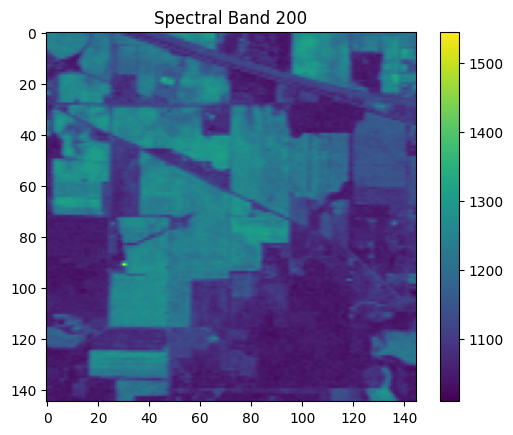

In [44]:
# Select a single spectral band (e.g., band 100)
band = 200
plt.imshow(indian_pines[:, :, band], cmap='viridis')
plt.title(f'Spectral Band {band}')
plt.colorbar()
plt.show()


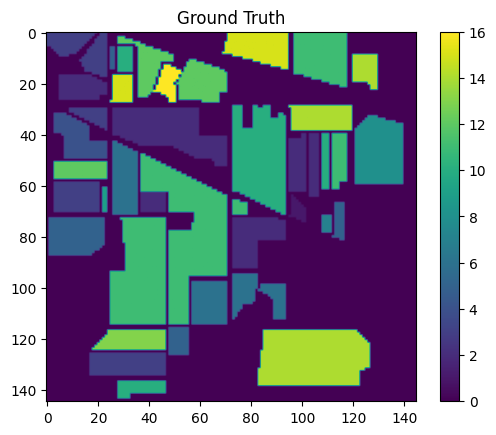

In [45]:
# Plot the ground truth data
plt.imshow(ground_truth, cmap='viridis')
plt.title('Ground Truth')
plt.colorbar()
plt.show()

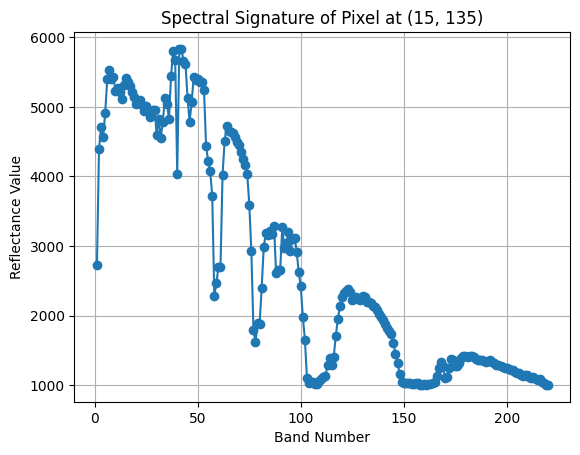

In [59]:
# Randomly select a pixel (x, y)
pix_x = np.random.randint(0, height)
pix_y = np.random.randint(0, width)

# Extract the spectral values for the selected pixel
spectral_values = indian_pines[pix_x, pix_y, :]

# Plot the spectral values across all bands
plt.plot(np.arange(1, num_bands + 1), spectral_values, marker='o')
plt.title(f'Spectral Signature of Pixel at ({pix_x}, {pix_y})')
plt.xlabel('Band Number')
plt.ylabel('Reflectance Value')
plt.grid(True)
plt.show()


In [79]:
from sklearn.decomposition import PCA

# Flatten the image for PCA
X = indian_pines.reshape(-1, indian_pines.shape[2])

# Perform PCA
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X)

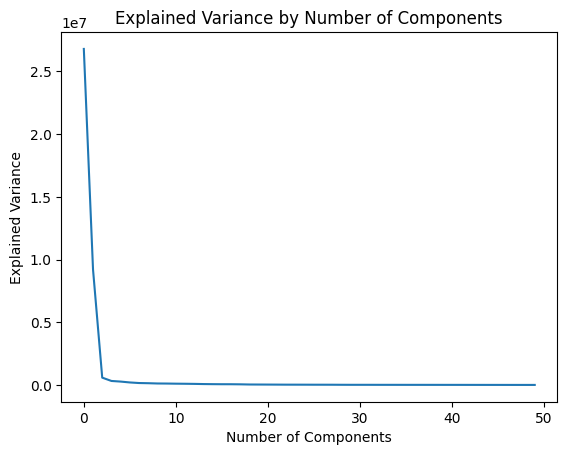

In [80]:
plt.plot(pca.explained_variance_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.show()


><font size="4">Explained Variance vs. Model Performance </font>

<font size="3">PCA (Principal Component Analysis) helps to reduce the dimensionality of data by transforming it into a set of orthogonal components that capture the most variance.<br>
While the explained variance by the first two principal components may be high, including additional components (n=50) can still improve model performance by capturing residual information and intricate patterns not fully explained by the initial components.</font>

In [84]:
# Flatten the ground truth array
y = ground_truth.reshape(-1)
print('y shape: ',y.shape)
print('X_pca shape:',X_pca.shape)
# Remove unlabeled data (0 is the label for unlabeled data)
X_pca_labeled = X_pca[y > 0]
y_labeled = y[y > 0]


y shape:  (21025,)
X_pca shape: (21025, 50)


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_labeled, y_labeled, test_size=0.3, random_state=42)


In [91]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Initialize and train the Logistic Regression model
lr = LogisticRegression(max_iter=1000, random_state=42)
# Create pipe to scale the data and fit model
pipe = make_pipeline(StandardScaler(), lr)
pipe.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = pipe.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

# Detailed classification report
print(classification_report(y_test, y_pred_lr))



Logistic Regression Accuracy: 0.7622764227642277
              precision    recall  f1-score   support

           1       1.00      0.59      0.74        22
           2       0.67      0.70      0.69       407
           3       0.70      0.50      0.59       253
           4       0.55      0.39      0.46        61
           5       0.90      0.91      0.90       137
           6       0.95      0.95      0.95       222
           7       0.89      0.89      0.89         9
           8       0.92      0.99      0.95       133
           9       0.50      0.75      0.60         4
          10       0.68      0.64      0.66       315
          11       0.68      0.80      0.73       719
          12       0.68      0.58      0.63       191
          13       1.00      0.96      0.98        57
          14       0.91      0.95      0.93       378
          15       0.77      0.64      0.70       138
          16       1.00      0.83      0.91        29

    accuracy                   

In [89]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8052032520325203
              precision    recall  f1-score   support

           1       1.00      0.45      0.62        22
           2       0.67      0.78      0.72       407
           3       0.86      0.54      0.66       253
           4       0.67      0.26      0.38        61
           5       0.93      0.92      0.92       137
           6       0.90      0.97      0.94       222
           7       1.00      0.67      0.80         9
           8       0.90      1.00      0.95       133
           9       1.00      0.50      0.67         4
          10       0.79      0.76      0.77       315
          11       0.75      0.88      0.81       719
          12       0.76      0.60      0.67       191
          13       0.98      0.95      0.96        57
          14       0.91      0.98      0.94       378
          15       0.80      0.57      0.66       138
          16       1.00      0.79      0.88        29

    accuracy                         

In [98]:
# Initialize and train the XGBoost model
import xgboost as xgb
# xgb needs labels to start from 0
y_xgb = y_labeled - np.min(y_labeled)

# Split the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_pca_labeled, y_xgb, test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))

print(classification_report(y_test_xgb, y_pred_xgb))


XGBoost Accuracy: 0.8390243902439024
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        22
           1       0.78      0.79      0.79       407
           2       0.86      0.70      0.77       253
           3       0.62      0.59      0.61        61
           4       0.91      0.91      0.91       137
           5       0.94      0.97      0.95       222
           6       1.00      0.56      0.71         9
           7       0.92      0.98      0.95       133
           8       0.60      0.75      0.67         4
           9       0.79      0.79      0.79       315
          10       0.80      0.88      0.84       719
          11       0.77      0.71      0.74       191
          12       1.00      0.96      0.98        57
          13       0.92      0.97      0.94       378
          14       0.82      0.64      0.72       138
          15       0.96      0.93      0.95        29

    accuracy                           0.84

In [99]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predict on the test set
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the model
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))


MLP Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

           1       0.94      0.73      0.82        22
           2       0.77      0.68      0.72       407
           3       0.82      0.68      0.75       253
           4       0.60      0.59      0.60        61
           5       0.92      0.86      0.89       137
           6       0.93      0.94      0.93       222
           7       0.78      0.78      0.78         9
           8       0.93      0.99      0.96       133
           9       0.57      1.00      0.73         4
          10       0.79      0.55      0.65       315
          11       0.67      0.90      0.77       719
          12       0.85      0.63      0.72       191
          13       0.93      0.93      0.93        57
          14       0.96      0.87      0.91       378
          15       0.63      0.76      0.69       138
          16       0.92      0.79      0.85        29

    accuracy                           0.79    

In [104]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
print("k-NN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


k-NN Accuracy: 0.7463414634146341
              precision    recall  f1-score   support

           1       0.93      0.59      0.72        22
           2       0.59      0.69      0.63       407
           3       0.66      0.57      0.61       253
           4       0.41      0.43      0.42        61
           5       0.84      0.89      0.87       137
           6       0.83      0.97      0.90       222
           7       0.67      0.89      0.76         9
           8       0.93      0.98      0.95       133
           9       0.50      0.75      0.60         4
          10       0.71      0.79      0.74       315
          11       0.75      0.76      0.76       719
          12       0.72      0.42      0.53       191
          13       0.86      0.96      0.91        57
          14       0.90      0.93      0.91       378
          15       0.66      0.35      0.45       138
          16       1.00      0.90      0.95        29

    accuracy                           0.75   

As expected xgboost gives the highest accuracy for this classification task. Model parameter configuration was minimal so all models could improve. Considering a quick implementation without the need for hyperparameter search xgb seems to be the ideal model of choice here